## Telecom Customer Churn Analysis

Author: Raghad Alotaibi

# 1. Improt libraries 

In [1]:
import numpy as np
import pandas as pd

import plotly as py
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import  Pipeline
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [2]:
import warnings
warnings.filterwarnings('ignore')

# 2. Read the data

In [3]:
url = 'https://drive.google.com/file/d/18m0m8s4RgSe7l8uHbrQVcDCSkCuK24wE/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df = pd.read_csv(path)

## data description 

In [4]:
#  dataset shape with number of rows and columns
df.shape

(7043, 32)

In [5]:
#sample
df.head()

CustomerID  Count        Country       State         City  Zip Code  \
0  3668-QPYBK      1  United States  California  Los Angeles     90003   
1  9237-HQITU      1  United States  California  Los Angeles     90005   
2  9305-CDSKC      1  United States  California  Los Angeles     90006   
3  7892-POOKP      1  United States  California  Los Angeles     90010   
4  0280-XJGEX      1  United States  California  Los Angeles     90015   

                 Lat Long   Latitude   Longitude  Gender  ...  \
0  33.964131, -118.272783  33.964131 -118.272783    Male  ...   
1   34.059281, -118.30742  34.059281 -118.307420  Female  ...   
2  34.048013, -118.293953  34.048013 -118.293953  Female  ...   
3  34.062125, -118.315709  34.062125 -118.315709  Female  ...   
4  34.039224, -118.266293  34.039224 -118.266293    Male  ...   

  Streaming Movies        Contract Paperless Billing  \
0               No  Month-to-month               Yes   
1               No  Month-to-month               Yes   
2              Yes  Month-to-month               Yes   
3              Yes  Month-to-month               Yes   
4              Yes  Month-to-month               Yes   

              Payment Method Monthly Charges Total Charges Churn Label  \
0               Mailed check           53.85        108.15         Yes   
1           Electronic check           70.70        151.65         Yes   
2           Electronic check           99.65         820.5         Yes   
3           Electronic check          104.80       3046.05         Yes   
4  Bank transfer (automatic)          103.70        5036.3         Yes   

  Churn Value  CLTV                   Churn Reason  
0           1  3239   Competitor made better offer  
1           1  2701                          Moved  
2           1  5372                          Moved  
3           1  5003                          Moved  
4           1  5340  Competitor had better devices  

[5 rows x 32 columns]

## Traget Vaiable = Churn Value

In [6]:
# columns data types 
df.dtypes

CustomerID            object
Count                  int64
Country               object
State                 object
City                  object
Zip Code               int64
Lat Long              object
Latitude             float64
Longitude            float64
Gender                object
Senior Citizen        object
Partner               object
Dependents            object
Tenure Months          int64
Phone Service         object
Multiple Lines        object
Internet Service      object
Online Security       object
Online Backup         object
Device Protection     object
Tech Support          object
Streaming TV          object
Streaming Movies      object
Contract              object
Paperless Billing     object
Payment Method        object
Monthly Charges      float64
Total Charges         object
Churn Label           object
Churn Value            int64
CLTV                   int64
Churn Reason          object
dtype: object

In [7]:
# convert total charger to float
df["Total Charges"] = pd.to_numeric(df["Total Charges"], errors='coerce')

In [8]:
# totaal charges having 11 null values due to empty cells = white sapce
df.isnull().sum()

CustomerID              0
Count                   0
Country                 0
State                   0
City                    0
Zip Code                0
Lat Long                0
Latitude                0
Longitude               0
Gender                  0
Senior Citizen          0
Partner                 0
Dependents              0
Tenure Months           0
Phone Service           0
Multiple Lines          0
Internet Service        0
Online Security         0
Online Backup           0
Device Protection       0
Tech Support            0
Streaming TV            0
Streaming Movies        0
Contract                0
Paperless Billing       0
Payment Method          0
Monthly Charges         0
Total Charges          11
Churn Label             0
Churn Value             0
CLTV                    0
Churn Reason         5174
dtype: int64

In [9]:
df.dropna(subset=['Total Charges'],inplace=True)

In [10]:
df.isnull().sum()

CustomerID              0
Count                   0
Country                 0
State                   0
City                    0
Zip Code                0
Lat Long                0
Latitude                0
Longitude               0
Gender                  0
Senior Citizen          0
Partner                 0
Dependents              0
Tenure Months           0
Phone Service           0
Multiple Lines          0
Internet Service        0
Online Security         0
Online Backup           0
Device Protection       0
Tech Support            0
Streaming TV            0
Streaming Movies        0
Contract                0
Paperless Billing       0
Payment Method          0
Monthly Charges         0
Total Charges           0
Churn Label             0
Churn Value             0
CLTV                    0
Churn Reason         5163
dtype: int64

In [11]:
df.describe()

Count      Zip Code     Latitude    Longitude  Tenure Months  \
count  7032.0   7032.000000  7032.000000  7032.000000    7032.000000   
mean      1.0  93523.032565    36.283307  -119.799215      32.421786   
std       0.0   1865.515958     2.456118     2.157588      24.545260   
min       1.0  90001.000000    32.555828  -124.301372       1.000000   
25%       1.0  92102.000000    34.030915  -121.815412       9.000000   
50%       1.0  93552.500000    36.391777  -119.735410      29.000000   
75%       1.0  95354.000000    38.227285  -118.043237      55.000000   
max       1.0  96161.000000    41.962127  -114.192901      72.000000   

       Monthly Charges  Total Charges  Churn Value         CLTV  
count      7032.000000    7032.000000  7032.000000  7032.000000  
mean         64.798208    2283.300441     0.265785  4401.445108  
std          30.085974    2266.771362     0.441782  1182.414266  
min          18.250000      18.800000     0.000000  2003.000000  
25%          35.587500     401.450000     0.000000  3469.750000  
50%          70.350000    1397.475000     0.000000  4527.500000  
75%          89.862500    3794.737500     1.000000  5381.000000  
max         118.750000    8684.800000     1.000000  6500.000000

### The average customer relationship 32 months and pays monthly 64.76 
### The longest customer relationship is 72 months -> 6 years and pays monthly 118.75

In [12]:
# number of rows and columns
df.shape

(7032, 32)

# 3. Exploratory Data Analysis  (EDA) 

## Missing data

<AxesSubplot: >

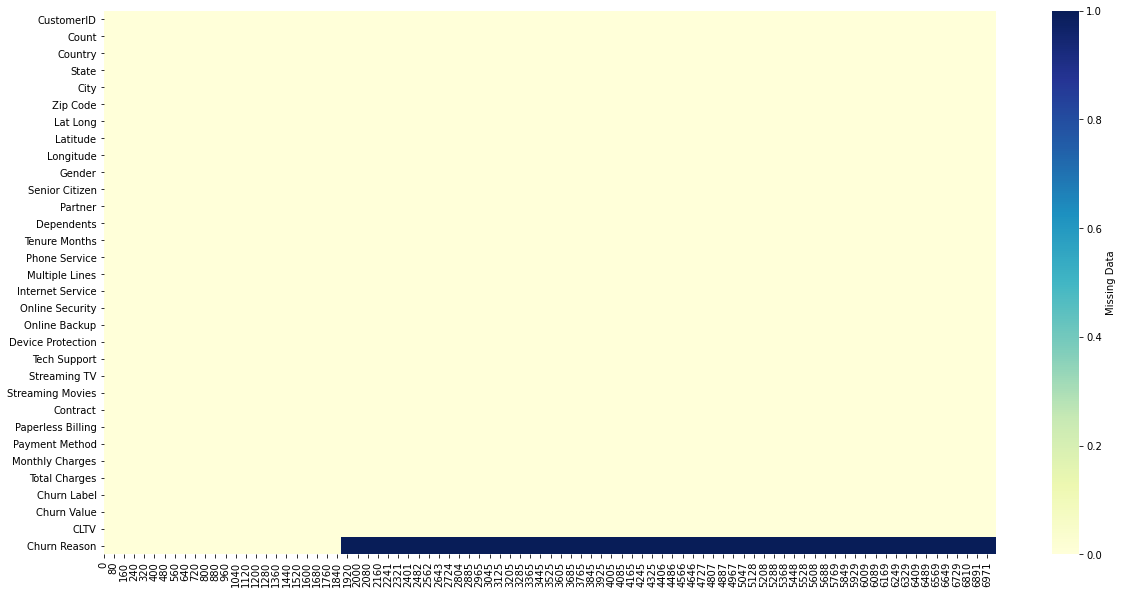

In [13]:
# missing data check 
plt.figure(figsize=(20,10))
sns.heatmap(df.isnull().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})

## Frequency Analysis

In [14]:
# churned frequency 
fig = px.histogram(df, x="Churn Label",
             color=df["Churn Label"],
             text_auto=True,
             color_discrete_map={'Yes':'darkblue','No':'lightBlue'},
             )
   
fig.update_layout(showlegend=False)
fig.show()

In [15]:
# percentage of churn
df["Churn Label"].value_counts(normalize=True)*100

No     73.421502
Yes    26.578498
Name: Churn Label, dtype: float64

In [16]:
# top churn reasons
df["Churn Reason"].value_counts()

Attitude of support person                   192
Competitor offered higher download speeds    189
Competitor offered more data                 162
Don't know                                   154
Competitor made better offer                 140
Attitude of service provider                 135
Competitor had better devices                130
Network reliability                          103
Product dissatisfaction                      102
Price too high                                98
Service dissatisfaction                       89
Lack of self-service on Website               88
Extra data charges                            57
Moved                                         53
Limited range of services                     44
Long distance charges                         44
Lack of affordable download/upload speed      44
Poor expertise of phone support               20
Poor expertise of online support              19
Deceased                                       6
Name: Churn Reason, 

In [17]:
# discovering the number of months before churn
fig = px.histogram(df, x="Tenure Months", 
                   nbins=15, 
                   color="Churn Label",
                   text_auto=True,
                   facet_col= 'Churn Label',
                   color_discrete_map={'Yes':'darkblue','No':'lightBlue'})



fig.update_layout(bargap=0.02)

fig.show()


### new customers (0-4 month) have the highest number of churners, 
### Number of customers decrease as the tenure duration increases 

In [18]:
# discovering the number of Tenure months by contract type 
fig = px.histogram(df, x="Tenure Months", 
                   nbins=15, 
                   color="Contract",
                   text_auto=True,
                   facet_col= 'Contract')



fig.update_layout(bargap=0.02)

fig.show()



### most of monthly contractors subsribe for (0-4 month)
### most of customers with two-year contract type stayes for (70-74 months) (more loyal)


In [19]:
# discovering the number of churners by contract type
fig = px.histogram(df, x="Contract", 
                   nbins=15, 
                   color="Churn Label",
                   text_auto=True,
                   facet_col= 'Churn Label',
                   color_discrete_map={'Yes':'darkblue','No':'lightBlue'})



fig.update_layout(bargap=0.02)

fig.show()

### churn happen less in long contract types (one-two years) 

In [20]:
# disccovering the monthly charges with churn
fig = px.histogram(df, x="Monthly Charges", 
                   nbins=20, 
                   color="Churn Label",
                   text_auto=True,
                   facet_col= 'Churn Label',
                   color_discrete_map={'Yes':'darkblue','No':'lightBlue'})


fig.update_layout(bargap=0.02)

fig.show()

### majority of non-churned customers (933) are paying (20-29.99) monthly charges, 
### the highest number of churned customers are paying(70-70.99) monthly charges (above avg = 64.76)

### demographic data frequency analysis

In [21]:
fig = px.histogram(df, x="Gender",
             color=df["Churn Label"],
             text_auto=True,
             color_discrete_map={'Yes':'darkblue','No':'lightBlue'},
             barmode = 'group')
   
fig.show()

In [22]:
df.Gender.value_counts()

Male      3549
Female    3483
Name: Gender, dtype: int64

In [23]:
df.Gender.value_counts(normalize=True)*100

Male      50.469283
Female    49.530717
Name: Gender, dtype: float64

### number of female and male customers are close (hence not very indicative of churn or service marketing)

In [24]:
fig = px.histogram(df, x="Gender",
             color=df["Senior Citizen"],
             text_auto=True,
             #color_discrete_map={'Yes':'darkblue','No':'lightBlue'},
             barmode = 'group')
   
fig.show()

### in case of senior citizens, there is no significant gender difference.

In [25]:
fig = px.histogram(df, x="Gender",
             color=df["Partner"],
             text_auto=True,
             #color_discrete_map={'Yes':'darkblue','No':'lightBlue'},
             barmode = 'group')
   
fig.show()

### colse number of partners in both genders

In [26]:
fig = px.histogram(df, x="Gender",
             color=df["Dependents"],
             text_auto=True,
             #color_discrete_map={'Yes':'darkblue','No':'lightBlue'},
             barmode = 'group')
   
fig.show()

### similar results for both genders 

In [27]:
fig = px.histogram(df, x="Phone Service",
             color=df["Churn Label"],
             text_auto=True,
             color_discrete_map={'Yes':'darkblue','No':'lightBlue'},
             barmode = 'group')
   
fig.show()

### majorty of cutomers are subscribed to phone service 
### and the majority of chunred cutomers also were subscribed to phone service

In [28]:
fig = px.histogram(df, x="Internet Service",
             color=df["Churn Label"],
             text_auto=True,
             color_discrete_map={'Yes':'darkblue','No':'lightBlue'},
             barmode = 'group')
   
fig.show()

### 69.3% of churnered customers were subscribed to "fiber optic" internet service

In [29]:
# concatenate phone service and internet service columns
df['Phone and Internet']= df['Phone Service']  +"-"+  df["Internet Service"]

In [30]:
fig = px.histogram(df, x="Phone and Internet",
             color=df["Churn Label"],
             text_auto=True,
             color_discrete_map={'Yes':'darkblue','No':'lightBlue'},
             barmode = 'group')
   
fig.show()

### the customers having phone service and DSL internet are more satisfied than customers with phone services and Fiber optic Internet

## Correlation Analysis

In [31]:
# correlation using the method pearson : standard correlation coefficient
df.corr()

Count  Zip Code  Latitude  Longitude  Tenure Months  \
Count              NaN       NaN       NaN        NaN            NaN   
Zip Code           NaN  1.000000  0.895795  -0.784273       0.000287   
Latitude           NaN  0.895795  1.000000  -0.876777      -0.002100   
Longitude          NaN -0.784273 -0.876777   1.000000      -0.001477   
Tenure Months      NaN  0.000287 -0.002100  -0.001477       1.000000   
Monthly Charges    NaN -0.004956 -0.020302   0.024513       0.246862   
Total Charges      NaN -0.001462 -0.010313   0.009047       0.825880   
Churn Value        NaN  0.003006 -0.003600   0.004693      -0.354049   
CLTV               NaN -0.004512  0.000137   0.000953       0.396188   

                 Monthly Charges  Total Charges  Churn Value      CLTV  
Count                        NaN            NaN          NaN       NaN  
Zip Code               -0.004956      -0.001462     0.003006 -0.004512  
Latitude               -0.020302      -0.010313    -0.003600  0.000137  
Longitude               0.024513       0.009047     0.004693  0.000953  
Tenure Months           0.246862       0.825880    -0.354049  0.396188  
Monthly Charges         1.000000       0.651065     0.192858  0.098565  
Total Charges           0.651065       1.000000    -0.199484  0.341837  
Churn Value             0.192858      -0.199484     1.000000 -0.128253  
CLTV                    0.098565       0.341837    -0.128253  1.000000

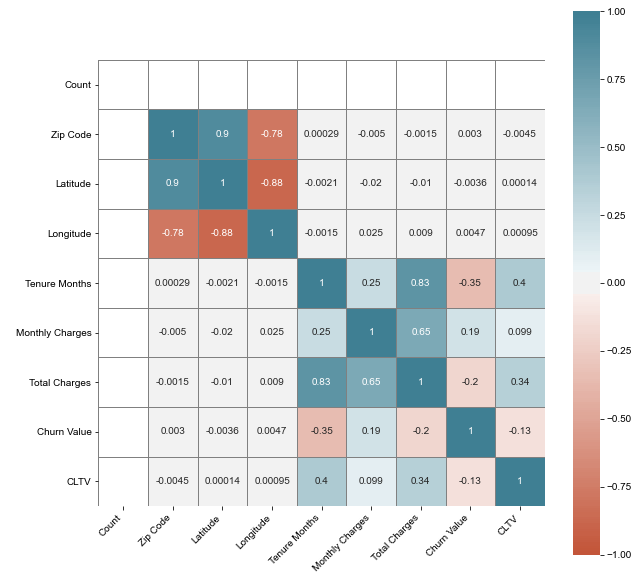

In [32]:
plt.figure(figsize = (10,10))

ax = sns.heatmap(
    df.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True,
    #fmt='.1g',
    linewidth=1, linecolor="gray"
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
sns.set(font_scale=0.1)


## Outliers Analysis

In [33]:
# box plot for each numerical value
for i in df.select_dtypes(include=['int64','float64']):
    px.box(data_frame = df,
             x = i,
             width=750,
             height=450).show()

### no ouliers detected 

In [34]:
#customer churn location distribution 
fig = px.scatter_mapbox(df, lat="Latitude",
                        lon="Longitude",
                        color="Churn Label",
                        mapbox_style='open-street-map')
fig.show()

# 4. Data Preprocessing & Feature Engineering 


    - Phone and Internet : concatenate Phone Service & Internet Service (in previous sections)
    - impute null churn reason with value "Not Churned" 
    - categorical data encoding
    - numerical data transformation (standarization : z = (x - mean) / standard deviation) 
    - data balancing (oversampling with SMOTE) [(26.53%) of churn]


In [35]:
df["Churn Reason"].fillna("Not Churned", inplace = True)

In [36]:
df["Churn Reason"].value_counts()

Not Churned                                  5163
Attitude of support person                    192
Competitor offered higher download speeds     189
Competitor offered more data                  162
Don't know                                    154
Competitor made better offer                  140
Attitude of service provider                  135
Competitor had better devices                 130
Network reliability                           103
Product dissatisfaction                       102
Price too high                                 98
Service dissatisfaction                        89
Lack of self-service on Website                88
Extra data charges                             57
Moved                                          53
Lack of affordable download/upload speed       44
Long distance charges                          44
Limited range of services                      44
Poor expertise of phone support                20
Poor expertise of online support               19


In [37]:
df.dtypes

CustomerID             object
Count                   int64
Country                object
State                  object
City                   object
Zip Code                int64
Lat Long               object
Latitude              float64
Longitude             float64
Gender                 object
Senior Citizen         object
Partner                object
Dependents             object
Tenure Months           int64
Phone Service          object
Multiple Lines         object
Internet Service       object
Online Security        object
Online Backup          object
Device Protection      object
Tech Support           object
Streaming TV           object
Streaming Movies       object
Contract               object
Paperless Billing      object
Payment Method         object
Monthly Charges       float64
Total Charges         float64
Churn Label            object
Churn Value             int64
CLTV                    int64
Churn Reason           object
Phone and Internet     object
dtype: obj

# 5. Methodology

In [38]:
# splitting the data to training and testing sets

df_model = df.copy()
X = df_model.drop('Churn Value', axis = 1)
y = df_model['Churn Value']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# shape of train and test splits
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((4922, 32), (2110, 32), (4922,), (2110,))

### Logistic Regression pipeline

In [39]:
numeric_features = ['Tenure Months','Monthly Charges','Total Charges','CLTV']
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

In [40]:
categorical_features = ['City','Gender','Senior Citizen','Partner',
                       'Dependents','Phone Service','Multiple Lines',
                       'Internet Service','Online Security','Online Backup',
                       'Device Protection','Tech Support','Streaming TV',
                       'Streaming Movies','Contract','Paperless Billing','Payment Method',
                       'Churn Reason','Phone and Internet']

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [41]:
ColumnTransform = ColumnTransformer(
    transformers=
    [('drop_columns', 'drop', ['CustomerID',
                               'Count',
                               'Country',
                               'State',
                               'Zip Code',
                               'Lat Long',
                               'Latitude',
                               'Longitude',
                               'Churn Label'
                               ]),
    
     ('num', numeric_transformer, numeric_features),
     ('cat', categorical_transformer, categorical_features)])

In [42]:
sm = SMOTE(random_state = 0)

In [43]:
pipeline = Pipeline([('preprocessor', ColumnTransform),
                          ('SMOTE', sm),
                          ('model', LogisticRegression(random_state=10))])

In [44]:
parameters = {"model__solver" : ['newton-cg', 'lbfgs', 'liblinear'],
              "model__C":[0.001, 0.0001]}

solver = Algorithm to use in the optimization problem. (Each solver tries to find the parameter weights that minimize a cost function) - Gradient Descent

C = Inverse of regularization strength; must be a positive float, smaller values specify stronger regularization. (a penalty term meant to regulate against overfitting.)

In [45]:
cv = GridSearchCV(pipeline,
                  param_grid = parameters,
                  scoring='accuracy',
                  cv=10)

In [46]:
cv.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('drop_columns',
                                                                         'drop',
                                                                         ['CustomerID',
                                                                          'Count',
                                                                          'Country',
                                                                          'State',
                                                                          'Zip '
                                                                          'Code',
                                                                          'Lat '
                                                                          'Long',
                                                                          'Latitude',
                                                                          'Longitude',
                                                                          'Churn '
                                                                          'Label']),
                                                                        ('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Tenure '
                                                                          'Months',
                                                                          'Monthly '
                                                                          'Charges',
                                                                          'Total '
                                                                          'Charges',
                                                                          'CLTV']),
                                                                        ('cat',
                                                                         Pipelin...
                                                                          'Device '
                                                                          'Protection',
                                                                          'Tech '
                                                                          'Support',
                                                                          'Streaming '
                                                                          'TV',
                                                                          'Streaming '
                                                                          'Movies',
                                                                          'Contract',
                                                                          'Paperless '
                                                                          'Billing',
                                                                          'Payment '
                                                                          'Method',
                                                                          'Churn '
                                                                          'Reason',
                                                                          'Phone '
                                                                          'and '
                                                                          'Internet'])])),
                                       ('SMOTE', SMOTE(random_state=0)),
                                       ('model',
                                        LogisticRegress

In [47]:
 y_pred = cv.best_estimator_.predict(X_test)

In [48]:
# best score
cv.best_estimator_.score(X_test, y_test)

0.890521327014218

In [49]:
# model evaluation
labels = np.unique(y_pred)
confusion_mat = confusion_matrix(y_test, y_pred, labels=labels)
accuracy = (y_pred == y_test).mean()

print("Labels:", labels)
print("\nConfusion Matrix:\n", confusion_mat)
print("\nAccuracy:", accuracy)
print("\nBest Parameters:", cv.best_params_)

Labels: [0 1]

Confusion Matrix:
 [[1369  188]
 [  43  510]]

Accuracy: 0.890521327014218

Best Parameters: {'model__C': 0.001, 'model__solver': 'liblinear'}


In [50]:
# claassification report 
class_report = classification_report(y_test, y_pred, zero_division=0)

print("The model's Accuracy:  ",(y_pred == y_test).mean())
print("\nClassification Report: \n", class_report)

The model's Accuracy:   0.890521327014218

Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.88      0.92      1557
           1       0.73      0.92      0.82       553

    accuracy                           0.89      2110
   macro avg       0.85      0.90      0.87      2110
weighted avg       0.91      0.89      0.89      2110



Precision is the ratio of correctly predicted positive observations to the total predicted positive observations. What proportion of positive identifications was actually correct?

logistic regression model has a precision of 87.9% , when it predicts a customer is churned, it is correct 87.9% of the time.

Recall: answer what proportion of actual positives was identified correctly?

logistic regression model has a recall of 96.9%

If there are customers who have churned in the test set the model can identify it 92% of the time.

The precision and recall are often inconsistent, that is improving one reduces the other, therefore the F1 score is often used to find a balance between the precision and recall which gives equal importance to them both.

F1 = 2 x (precision x Recall) / (Precision + Recall) = 92.1%

## xgboost pipeline

In [51]:
pipeline2 = Pipeline([('preprocessor', ColumnTransform),
                       ('SMOTE', sm),
                       ('classifier',XGBClassifier(objective='reg:logistic'))])

In [52]:
parameters = {"classifier__n_estimators": [100, 120],
              "classifier__learning_rate": [0.01,0.001],
              "classifier__subsample": [1.0, 0.1],
              "classifier__colsample_bytree": [0.2],
              "classifier__max_depth": [3,5,6]
             }

- n_estimators: The number of trees in our ensemble. Equivalent to the number of boosting rounds.
- learning_rate: The learning rate determines the step size at each iteration while your model optimizes toward its objective. lower value = slower
- subsample: Represents the fraction of observations to be sampled for each tree.
- colsample_bytree: Represents the fraction of columns to be randomly sampled for each tree.
- max_depth: The maximum depth per tree.

In [53]:
cv = GridSearchCV(pipeline2,
                  param_grid = parameters,
                  scoring='accuracy',
                  cv=10)

In [54]:
cv_fit = cv.fit(X_train, y_train)

In [55]:
cv_fit

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('drop_columns',
                                                                         'drop',
                                                                         ['CustomerID',
                                                                          'Count',
                                                                          'Country',
                                                                          'State',
                                                                          'Zip '
                                                                          'Code',
                                                                          'Lat '
                                                                          'Long',
                                                                          'Latitude',
                                                                          'Longitude',
                                                                          'Churn '
                                                                          'Label']),
                                                                        ('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Tenure '
                                                                          'Months',
                                                                          'Monthly '
                                                                          'Charges',
                                                                          'Total '
                                                                          'Charges',
                                                                          'CLTV']),
                                                                        ('cat',
                                                                         Pipelin...
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      objective='reg:logistic',
                                                      predictor=None, ...))]),
             param_grid={'classifier__colsample_bytree': [0.2],
                         'classifier__learning_rate': [0.01, 0.001],
                         'classifier__max_depth': [3, 5, 6],
                         'classifier__n_estimators': [100, 120],
                         'classifier__subsample': [1.0, 0.1]},
             scoring='accuracy')

In [81]:
cv_fit.best_estimator_.score(X_test, y_test)

0.957345971563981

In [82]:
 y_pred = cv_fit.best_estimator_.predict(X_test)

In [83]:
labels = np.unique(y_pred)
confusion_mat = confusion_matrix(y_test, y_pred, labels=labels)
accuracy = (y_pred == y_test).mean()

print("Labels:", labels)
print("\nConfusion Matrix:\n", confusion_mat)
print("\nAccuracy:", accuracy)
print("\nBest Parameters:", cv.best_params_)

Labels: [0 1]

Confusion Matrix:
 [[1501   56]
 [  34  519]]

Accuracy: 0.957345971563981

Best Parameters: {'classifier__colsample_bytree': 0.2, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 6, 'classifier__n_estimators': 120, 'classifier__subsample': 1.0}


In [84]:


# evaluating the model using model's accuracy and classification report 
class_report = classification_report(y_test, y_pred, zero_division=0)

print("The model's Accuracy:  ",(y_pred == y_test).mean())
print("\nClassification Report: \n",class_report)

The model's Accuracy:   0.957345971563981

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.96      0.97      1557
           1       0.90      0.94      0.92       553

    accuracy                           0.96      2110
   macro avg       0.94      0.95      0.95      2110
weighted avg       0.96      0.96      0.96      2110



Precision is the ratio of correctly predicted positive observations to the total predicted positive observations. What proportion of positive identifications was actually correct?

xgboost model has a precision of 96.4% , when it predicts a customer is churned, it is correct 96.4% of the time.

Recall: answer what proportion of actual positives was identified correctly?

xgboost model has a recall of 97.7%

If there are customers who have churned in the test set the model can identify it 94% of the time.

F1 = 97.0%

## Feature Importance 

<AxesSubplot: >

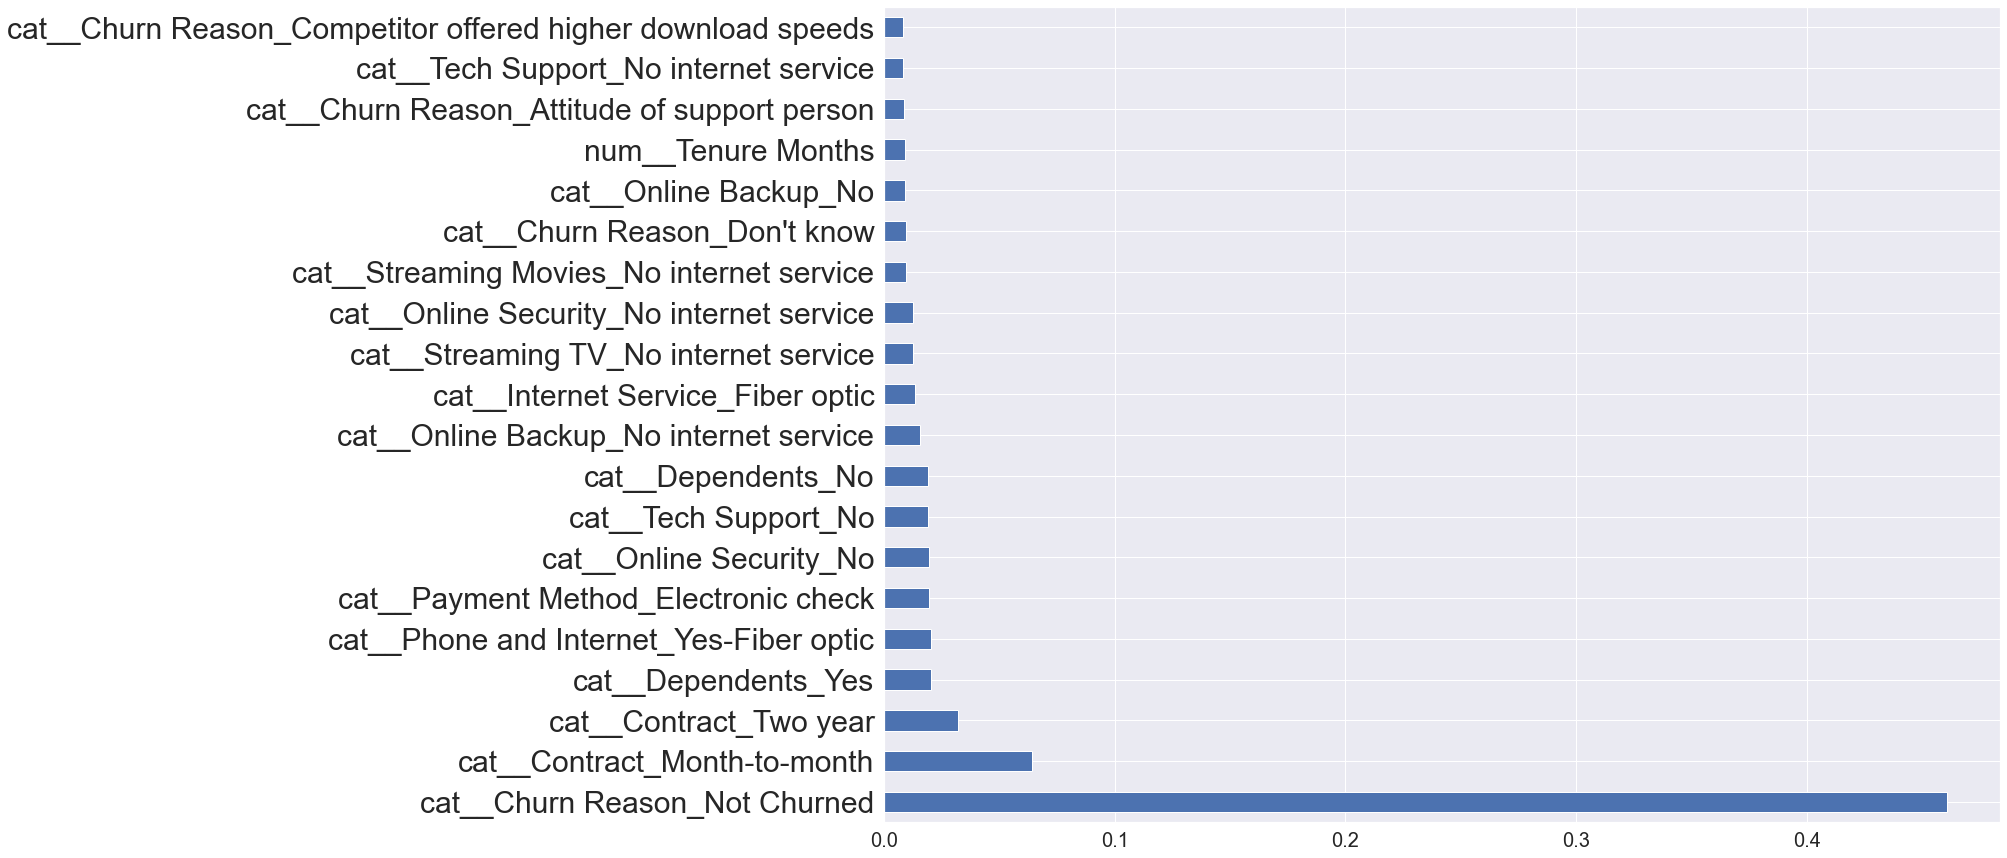

In [60]:


fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid()

plt.xticks( fontsize = 20)
plt.yticks( fontsize = 30)

feat_importances = pd.Series(cv_fit.best_estimator_.named_steps["classifier"].feature_importances_, 
                            index=cv_fit.best_estimator_.named_steps['preprocessor'].get_feature_names_out())

feat_importances.nlargest(20).plot(kind='barh',figsize=(20,15))



In [61]:
print(feat_importances.nlargest(20).sort_values(ascending=False).to_string())

cat__Churn Reason_Not Churned                                  0.460700
cat__Contract_Month-to-month                                   0.064268
cat__Contract_Two year                                         0.032169
cat__Dependents_Yes                                            0.020416
cat__Phone and Internet_Yes-Fiber optic                        0.020249
cat__Payment Method_Electronic check                           0.019571
cat__Online Security_No                                        0.019503
cat__Tech Support_No                                           0.019293
cat__Dependents_No                                             0.018923
cat__Online Backup_No internet service                         0.015557
cat__Internet Service_Fiber optic                              0.013512
cat__Streaming TV_No internet service                          0.012794
cat__Online Security_No internet service                       0.012577
cat__Streaming Movies_No internet service                      0

### Tenure and longer contracts variables have positive impact in predicting the churn
### phone and interent Fiber optic is highly affecting churn

# Takeaway 1

### What are the insights for customers who are high likely to churn

In [62]:
#subset churners data 
df_churners = df.loc[df["Churn Label"] == 'Yes']

In [63]:
df_churners.nunique()

CustomerID            1869
Count                    1
Country                  1
State                    1
City                   833
Zip Code              1190
Lat Long              1190
Latitude              1190
Longitude             1190
Gender                   2
Senior Citizen           2
Partner                  2
Dependents               2
Tenure Months           72
Phone Service            2
Multiple Lines           3
Internet Service         3
Online Security          3
Online Backup            3
Device Protection        3
Tech Support             3
Streaming TV             3
Streaming Movies         3
Contract                 3
Paperless Billing        2
Payment Method           4
Monthly Charges        910
Total Charges         1732
Churn Label              1
Churn Value              1
CLTV                  1487
Churn Reason            20
Phone and Internet       4
dtype: int64

In [64]:
df_churners.City.nunique()

833

In [65]:
# churned cutomers relationship in months 
fig = px.histogram(df_churners, x="Tenure Months", 
                   nbins=15, 
                   color="Churn Label",
                   text_auto=True,
                   color_discrete_map={'Yes':'darkblue','No':'lightBlue'})
fig.show()

### most cchurn happen in (0-4 months) tenure period

In [66]:

df_churners_top = df_churners['City'].value_counts().sort_values(ascending=False)[0:20].reset_index()

fig = px.histogram(df_churners_top, x="index", y="City",
             color='index',
             #color_discrete_sequence=('darkblue'),         
             
             text_auto=True,
             color_discrete_map={
                   'Los Angeles': 'darkblue'
,'San Diego' :'darkblue'
,'San Francisco' : 'darkblue'
,'San Jose' : 'darkblue'
,'Sacramento' : 'darkblue'
,'Fresno' : 'darkblue'
,'Long Beach' : 'darkblue'
,'Oakland' : 'darkblue'
,'Glendale' :'darkblue'
,'Stockton':'darkblue'
,'Modesto':'darkblue'
,'Santa Rosa':'darkblue'
,'Santa Barbara':'darkblue'
,'Berkeley':'darkblue'
,'Pasadena':'darkblue'
,'North Hollywood':'darkblue'
,'Riverside':'darkblue'
,'San Bernardino':'darkblue'
,'Torrance':'darkblue'
,'Anaheim':'darkblue'},
             
                  )

fig.update_xaxes(categoryorder='total descending')
fig.update_layout(showlegend=False)
fig.show()

In [67]:
fig = px.scatter_mapbox(df_churners, lat="Latitude",
                        lon="Longitude",
                        labels="City",
                        color="Churn Reason",
                        size_max=25,
                        mapbox_style='stamen-toner')
fig.show()

In [68]:
df_churners["Churn Reason"].value_counts()

Attitude of support person                   192
Competitor offered higher download speeds    189
Competitor offered more data                 162
Don't know                                   154
Competitor made better offer                 140
Attitude of service provider                 135
Competitor had better devices                130
Network reliability                          103
Product dissatisfaction                      102
Price too high                                98
Service dissatisfaction                       89
Lack of self-service on Website               88
Extra data charges                            57
Moved                                         53
Limited range of services                     44
Long distance charges                         44
Lack of affordable download/upload speed      44
Poor expertise of phone support               20
Poor expertise of online support              19
Deceased                                       6
Name: Churn Reason, 

In [69]:
df_churn_att = df_churners.loc[df_churners['Churn Reason'].isin(['Attitude of support person','Attitude of service provider'])]

In [70]:
df_churn_att['City'].value_counts()

San Diego        10
Los Angeles       5
Fresno            5
Santa Barbara     4
Glendale          4
                 ..
Hemet             1
Murrieta          1
Nuevo             1
Sun City          1
Indio             1
Name: City, Length: 263, dtype: int64

In [71]:
fig = px.histogram(df_churners, x='Gender', text_auto=True)
fig.show()

In [72]:
fig = px.histogram(df_churners, x='Senior Citizen', text_auto=True)
fig.show()

In [73]:
fig = px.histogram(df_churners, x="Phone and Internet",
             color=df_churners["Churn Label"],
             text_auto=True,
             color_discrete_map={'Yes':'darkblue','No':'lightBlue'})
   
fig.show()

# Takeaway 2

### Do we need to manage proactively the retention for high-value customers (CLTV)

Customer lifetime value is a measure of the total income a business can expect to bring in from a typical customer for as long as that person or account remains a client.

In [74]:
df.CLTV.describe()

count    7032.000000
mean     4401.445108
std      1182.414266
min      2003.000000
25%      3469.750000
50%      4527.500000
75%      5381.000000
max      6500.000000
Name: CLTV, dtype: float64

In [75]:
fig = px.histogram(df, x="CLTV", 
                   nbins=5, 
                   color="Churn Label",
                   text_auto=True,
                   facet_col= 'Churn Label',
                   color_discrete_map={'Yes':'darkblue','No':'lightBlue'})


fig.update_layout(bargap=0.02)

fig.show()

### majority of customer with higher CLTV are non-churned customers 
### the least churned customers are most valuable customers in CLTV (38 churned customer with CLTV 6000-6999)

In [76]:
#filter customers with cltv value 6000-6999

high_CLTV = df[(df['CLTV'] > 6000) & (df['CLTV'] < 6999)]

high_CLTV.shape

(426, 33)

In [77]:
high_CLTV["Churn Reason"].value_counts().sort_values(ascending=False)

Not Churned                                  388
Attitude of support person                     8
Competitor offered more data                   6
Long distance charges                          4
Competitor offered higher download speeds      3
Competitor had better devices                  3
Don't know                                     2
Attitude of service provider                   2
Price too high                                 2
Network reliability                            2
Lack of affordable download/upload speed       2
Extra data charges                             1
Product dissatisfaction                        1
Service dissatisfaction                        1
Competitor made better offer                   1
Name: Churn Reason, dtype: int64

### Top reasons are due to attitude and competitors offerings

In [78]:
# min Tenure months in high value costomers - at least 4 years
min(high_CLTV["Tenure Months"])

49

In [79]:
# tenure months of high CLTV customers

fig = px.histogram(high_CLTV, x="Tenure Months", 
                   nbins=5, 
                   color="Churn Label",
                   text_auto=True,
                   facet_col= 'Churn Label',
                   color_discrete_map={'Yes':'darkblue','No':'lightBlue'})


fig.update_layout(bargap=0.02)

fig.show()

### most high CLTV churned cutomers (11) happed in (50-54) Tenure months period approx >= 4 years

In [80]:
# how long do the high value customer until churn with reasons 

fig = px.histogram(high_CLTV.loc[high_CLTV['Churn Label'] == 'Yes'], x="Tenure Months", 
                   nbins=5, 
                   color="Churn Reason",
                   text_auto=True
                  )


fig.update_layout(bargap=0.02)

fig.show()

### customers with high CLTV value stay shorter with churn reasons related to the manner in which the service is provided, then competitor offerings